In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install umap-learn
!pip install bertopic


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [6]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters

    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods

        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)

        processed_texts = [self.preprocess_text(text) for text in texts]

        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")

    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)

        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]

        return labels, cluster_terms

    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)

        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )

        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)

        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]

        return labels, topic_terms

    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)

        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]

        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)

        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])

        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)

        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]

        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)

        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }

        return cluster_stats

In [7]:
# Prepare your data

products_df = pd.read_csv('/content/drive/MyDrive/david_project/final_products.csv')
texts = products_df['title'] + ' ' + products_df['combined_description']

In [8]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=50, max_clusters = 200)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='combined')

CLUSTERING BY KMEANS
CLUSTERING BY BERT


2025-02-09 05:02:47,176 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-09 05:03:32,527 - BERTopic - Dimensionality - Completed ✓
2025-02-09 05:03:32,530 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-09 05:03:32,992 - BERTopic - Cluster - Completed ✓
2025-02-09 05:03:33,017 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-09 05:03:34,485 - BERTopic - Representation - Completed ✓


CREATING FINAL CLUSTERING COMBINATION


In [10]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [11]:
# Number of total products
products_df.shape[0]

13700

In [12]:
# Number of clusters
len(cluster_stats)

200

In [13]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 164
Key Terms: straightener, hair, iron, odor, flat

Cluster Size: 80
Key Terms: decorations, compression, banner, birthday, party

Cluster Size: 138
Key Terms: straightener, hair, toothbrush, charcoal, bristles

Cluster Size: 10
Key Terms: vitamin, gummy, zinc, count capsule, capsule

Cluster Size: 116
Key Terms: sex, toy, ounces, vibrator, pounds

Cluster Size: 53
Key Terms: plugs, gluten free, protein, free, ear

Cluster Size: 109
Key Terms: mask, masks, battery powered, battery, rechargeable

Cluster Size: 132
Key Terms: neck, heat, wand, heating, massage

Cluster Size: 117
Key Terms: nutrisystem, ounce, bars, protein, chocolate

Cluster Size: 11
Key Terms: reading, eyeglass, white, 12, sunglasses



In [14]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

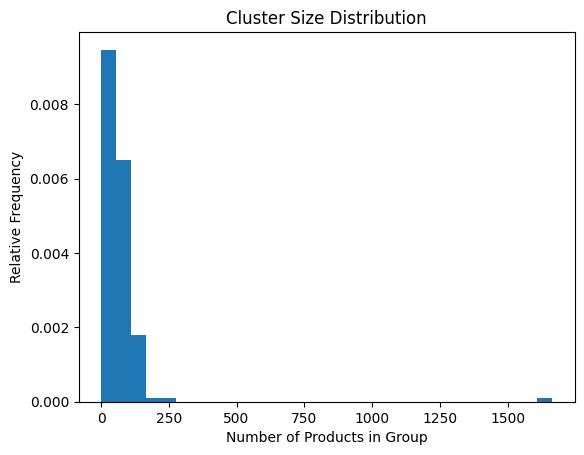

In [15]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [16]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

,count
label,
15,1665
179,271
83,204
0,164
28,152


In [19]:
# Largest Group Info
cluster_stats[15]

{'size': 1665,
 'terms': ['shaving', 'razor', 'adults', 'electric', 'kids'],
 'sample_products': ['Hausse Update Portable Exercise Pedal Bike- Tension Adjustable, Peddler Cycle with Electronic Display and Handle - Design for Legs and Arms No 154 x 157 x 118 inches 985 Pounds 1 AAA batteries required March 21 2018 Hausse',
  'Probasics Personal Hydraulic Patient Body Lift (with X-Large Full Body Mesh Sling w/Commode) No 50 x 25 x 15 inches 68 Pounds January 7 2019 Compass Health  MOVES EASILY Hydraulic lift has 5 front and rear casters that allow the patient lift to be moved and rotated easily Caster wheels lock in place easily by stepping on the lift plunger A portable patient lift that can be easily transported  HEAVY DUTY QUALITY Patient body lift can lift persons up to 450 Lbs Frame for the body lift is chip resistant  FITS UNDER MOST BEDS The adjustable width base allows the patient lift to be easily maneuvered under most beds or adjust around most places that a patient likes to si

In [20]:
#products_df.to_csv("data/labeled_tools_and_home_improvement_products.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'data'